# Step 4 - Simple Kriging one property

In [1]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing GemPy, which takes really long
import gempy as gp

# Importing auxiliary libraries
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy import spatial

In [2]:
domain = pd.read_csv("domain3d.csv")
data = pd.read_csv("data3d.csv")

In [3]:
# values from data analysis, as we have mean and std for SK
mean = 20.84
std = 5.68

In [4]:
#SK method, should be fine like this
def simple_kriging(point, mean, data, std):
    
    data_m = data.as_matrix(('X','Y','Z'))
    data_v = data['Property'].values
    
    C = np.zeros((len(data_m),len(data_m)))
    c = np.zeros((len(data_m)))
    w = np.zeros((len(data_m)))
    
    for i in range(len(data_m)):
        for j in range(len(data_m)):
            C[i,j] = gaussian_covariance(spatial.distance.euclidean(data_m[i], data_m[j]))
                     
        c[i] = gaussian_covariance(spatial.distance.euclidean(data_m[i], point))
    
    # nugget effect
    np.fill_diagonal(C, 0.1)
    
    w = np.linalg.solve(C,c)
    
    # SGS version - taking result from normal distribution with kriging mean an standard deviation
    result = np.random.normal(mean, scale=std) + sum(w*(data_v - mean))
    
    # direct version, calculating result from weights. Need to be normed to one
    #w_norm = w/np.sum(w)
    #result = np.sum(w_norm * data_v)
    
    return result

In [5]:
def select_closest_points(coordinate, data, n=25):
    """
    Method to select n closest points from the given coordinate to perform Cokriging with reasonable calculation
    time
    Args:
        coord (np.array): coordinates of point
        df (pandas.dataframe): dataframe containing coordinated and properties
    Returns
        df_cut (pandas.dataframe): dataframe containing only the 50 closest points
    """
    data_aux1 = data.copy()
    data_aux2 = data.as_matrix(('X','Y','Z'))
    
    dist = spatial.distance.cdist(coordinate, data_aux2) 
    data_aux1 = data.copy()
    
    dist_aux = dist.flatten()
    data_aux1['dist']= pd.Series(dist_aux)

    #data_aux3 = data_aux1.sort_values(by=['dist'])
    #closest_points = data_aux3[:n]
    closest_points = data_aux1.sort_values(by=['dist'])[:n]
    
    return closest_points

In [6]:
def gaussian_covariance(h):
    rng = 400
    sill = 33
    
    gamma = sill * (np.exp(-(abs(h)**2./(rng**2.))))
    
    return gamma

In [7]:
def gaussian_cov_model(d):
    """Gaussian model, m is [psill, range, nugget]"""
    rng = 400
    sill = 33
    
    gamma = sill * (1. - np.exp(-d**2./(rng*4./7.)**2.)) 
    
    return (-1)*(gamma-sill)

In [8]:
def perform_sgs(property_data, sgs_grid, mean, std):
    """
    Method to perform the SGS run, creating a new dataframe with the resulting grid, 
    containing the interpolated data fro the CoKriging
    Args:
        property_data (pandas.datframe): frame containing property data with corresponding X,Y,Z coordinates
        sgs_grid (pandas.dataframe): frame containing grid, meaning all X,Y,Z coordinates in domain 
    Returns:
        Result: Dataframe containg all interpolated values with corresponding coordinates       
    """
    results = pd.DataFrame(columns=property_data.columns)
    mean = mean
    std = std
    
    # both Input dfs should not be changed
    df_prop_calc = property_data.copy() #copy dataframe for appending results for SGS
    df_sgs_grid_calc = sgs_grid.copy() #copy of grid frame to delete data
    
    for i in range(0, len(sgs_grid)):
        
        # choose random point from df_sgs_grid_calc
        rand_pos = np.random.randint(0,len(df_sgs_grid_calc))
        random_coord = df_sgs_grid_calc.iloc[rand_pos].as_matrix(('X','Y','Z'))
        
        rand_coord_aux = np.array([random_coord])
        
        # delete point from the df sgs_grid_calc
        df_sgs_grid_calc = df_sgs_grid_calc.drop([rand_pos])
        df_sgs_grid_calc = df_sgs_grid_calc.reset_index() # reset indicies
        del df_sgs_grid_calc['index'] #reset indices
        
        # only select n closest points for Cokriging,best by selection to make it work with miguels code
        df_prop_calc_close = select_closest_points(rand_coord_aux, df_prop_calc)
        
        # perform the CoKriging interpolation on this point
        kriging_results = simple_kriging(random_coord, mean, df_prop_calc_close, std) 
        
        # set coordinates in result array
        new_interpolated_point = ([random_coord[0], random_coord[1],random_coord[2]])
        
        # add property interpolation to results array, depends a little bit on form of Kriging results
        new_interpolated_point.append(kriging_results)
                            
        # append result to df_prop_calc to use for further SGS
        df_prop_calc.loc[len(df_prop_calc)]=new_interpolated_point
        
        # append results to final results dataframe that will be returned
        results.loc[len(results)]=new_interpolated_point
        
    return results

In [9]:
%%time
results = perform_sgs(data, domain, mean, std)

Wall time: 1min 13s


In [10]:
# define the colormap
cmap = plt.cm.PuBu_r
# extract all colors
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5,.5,.5,1.0)
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0,40,8)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

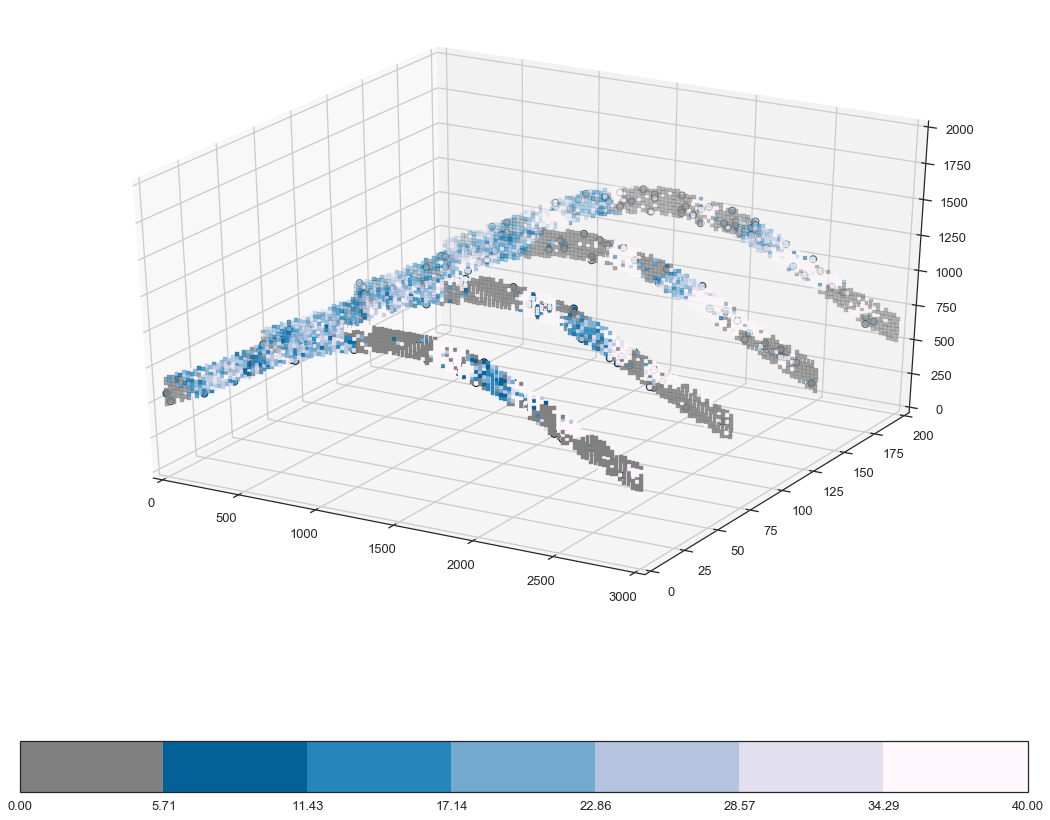

In [11]:
fig = plt.figure(figsize=(14, 12))
ax = Axes3D(fig)


ax.axes.set_zlim3d(0,2000)
ax.axes.set_xlim3d(0,3000)
ax.axes.set_ylim3d(0,200)
a = ax.scatter3D(xs=results.X,ys=results.Y,zs=results.Z, c=results.Property, s=15, marker=',', cmap=cmap, norm=norm)
b = ax.scatter3D(xs=data.X,ys=data.Y,zs=data.Z, c=data.Property, s=50, marker='o', cmap=cmap, norm=norm, linewidths=1, edgecolors='black')

fig.colorbar(a, orientation='horizontal')

In [12]:
results_f = results.loc[results['Y'] < 1]
data_f = data.loc[data['Y'] < 1]

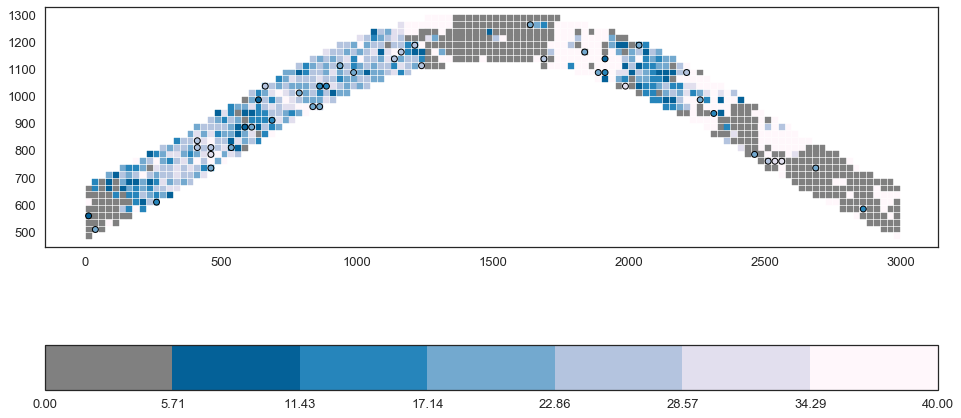

In [13]:
fig = plt.figure(figsize=(16,12))


a = plt.scatter(results_f.X, results_f.Z, c=results_f.Property, s=35, marker=',', cmap=cmap, norm=norm)
b = plt.scatter(data_f.X, data_f.Z, c=data_f.Property, s=35, marker='o', cmap=cmap, norm=norm, linewidths=1, edgecolors='black')

plt.axis('scaled')
fig.colorbar(a, orientation='horizontal')